# Empirical Algorithmic Implementation of Technical Analysis

Quantopian Post: https://www.quantopian.com/posts/an-empirical-algorithmic-evaluation-of-technical-analysis

Meduim Post: https://medium.com/automation-generation/algorithmically-detecting-and-trading-technical-chart-patterns-with-python-c577b3a396ed

Inspired by the paper by Andrew Lo, Harry Mamaysky, and Jiang Wang called "Foundations of Technical Analysis: Computational Algorithms, Statistical Inference, and Empirical Implementation (2000)". In the paper, the authors utilize non-parametric kernel regression to smooth a stock's daily price time series to a point where the local minima and maxima that a human technical analyst would find relevant can be separated from noisier short-term price fluctuations. The authors then search these denoised local minima and maxima for a few of the patterns commonly pursued by technical analysts. Once they've identified occurrences of particular patterns, the authors test their predictive power by observing the subsequent forward return on the stock.

For a fuller explanation of what is going on in this notebook, take a look at the original paper: https://www.cis.upenn.edu/~mkearns/teaching/cis700/lo.pdf

### Imports

In [2]:
from __future__ import division
from binance.client import Client
from BinanceKeys import BinanceKey1
import numpy as np
import pandas as pd
from statsmodels.nonparametric.kernel_regression import KernelReg
from numpy import linspace
import seaborn as sns
import time
import dateparser
from datetime import timedelta, datetime
from dateutil import parser
import pytz
import json
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import matplotlib.dates as mdates
matplotlib.style.use("ggplot")
from binance.enums import *
import pprint
import math
import os.path
import requests
from tqdm import tqdm_notebook 
import warnings
warnings.filterwarnings('ignore')

In [3]:
api_key = BinanceKey1['api_key']
api_secret = BinanceKey1['api_secret']
client = Client(api_key, api_secret)

In [4]:
### CONSTANTS
binsizes = {"1m": 1, "5m": 5, "1h": 60, "12h": 720, "1d": 1440}
batch_size = 750
binance_client = client

In [5]:
### FUNCTIONS
def minutes_of_new_data(symbol, kline_size, data, source):
    
    if len(data) > 0:  old = parser.parse(data["timestamp"].iloc[-1])
    elif source == "binance": old = datetime.strptime('15 Aug 2017', '%d %b %Y')
    if source == "binance": new = pd.to_datetime(binance_client.get_klines(symbol=symbol, interval=kline_size)[-1][0], unit='ms')
    return old, new

# Massage OHLCV data into Heiken Ashi candles
def Heiken_Ashi(dataframe):
    
    df = dataframe.copy()
    df.open = df.open.astype(float)
    df.high = df.high.astype(float)
    df.low = df.low.astype(float)
    df.close = df.close.astype(float)
    
    df['HA_Close']=(df.open + df.high + df.low + df.close)/4
    df.reset_index(inplace=True)
    ha_open = [ (df.open[0] + df.close[0]) / 2 ]
    [ ha_open.append((ha_open[i] + df.HA_Close.values[i]) / 2) \
    for i in range(0, len(df)-1) ]
    df['HA_Open'] = ha_open
    df['HA_High']=df[['HA_Open','HA_Close','high']].max(axis=1)
    df['HA_Low']=df[['HA_Open','HA_Close','low']].min(axis=1)
    
    return df

In [6]:
def get_all_binance(symbol, kline_size, save = False):
    
    filename = '%s_%s_%s_HK_data' % (symbol, kline_size, str(datetime.now().strftime('%Y_%m_%d')))
    if os.path.isfile(filename): data_df = pd.read_csv(filename)
    else: data_df = pd.DataFrame()
    oldest_point, newest_point = minutes_of_new_data(symbol, kline_size, data_df, source = "binance")
    delta_min = (newest_point - oldest_point).total_seconds()/60
    available_data = math.ceil(delta_min/binsizes[kline_size])
    if oldest_point == datetime.strptime('15 Aug 2017', '%d %b %Y'): print('Downloading all available %s data for %s. Be patient..!' % (kline_size, symbol))
    else: print('Downloading %d minutes of new data available for %s, i.e. %d instances of %s data.' % (delta_min, symbol, available_data, kline_size))
    klines = binance_client.get_historical_klines(symbol, kline_size, oldest_point.strftime("%d %b %Y %H:%M:%S"), newest_point.strftime("%d %b %Y %H:%M:%S"))
    
    data = pd.DataFrame(klines, columns = ['timestamp', 'open', 'high', 'low', 'close', 'volume', 'close_time', 'quote_av', 'trades', 'tb_base_av', 'tb_quote_av', 'ignore' ])
    data = data.drop(['ignore','close_time', 'quote_av', 'trades', 'tb_base_av', 'tb_quote_av'], axis=1)
    data['timestamp'] = pd.to_datetime(data['timestamp'], unit='ms')
    
    HA_DF = Heiken_Ashi(data)
    HA_DFx = HA_DF[["HA_Open", "HA_High", "HA_Low", "HA_Close"]]
    HA_DFx.columns = ['open','high','low','close']
    HA_DFx['volume'] = data['volume']
    HA_DFx['timestamp'] = data['timestamp']
    data = HA_DFx
    
    TS = data['timestamp'] 
    if len(data_df) > 0:
        temp_df = pd.DataFrame(data)
        data_df = data_df.append(temp_df)
    else: data_df = data
    if save: print('saving...')
    print('All caught up..!')
    return data_df

### Download BTCUSDT Prices 

In [7]:
#for symbol in list_of_symbols:
data_df = get_all_binance('BTCUSDT', '12h', save = False)

All caught up..!


In [8]:
cols = ['open', 'high', 'low', 'close', 'volume', 'timestamp']
data_df.columns = cols
data_df['timestamp'] = pd.to_datetime(data_df['timestamp'], unit='ms')
data_df.index = data_df.timestamp
data_df = data_df.drop('timestamp',axis=1)

In [9]:
data_df.head()

,open,high,low,close,volume
timestamp,,,,,
2017-08-17 00:00:00,4344.390000,4485.390000,4261.32,4358.8725,145.70874700
2017-08-17 12:00:00,4351.631250,4485.390000,4200.74,4351.8175,649.44163000
2017-08-18 00:00:00,4351.724375,4371.520000,4134.61,4282.8800,720.72220100
2017-08-18 12:00:00,4317.302187,4340.310000,3938.77,4176.9925,479.16606300
2017-08-19 00:00:00,4247.147344,4247.147344,3850.00,4025.1650,298.51856900


In [10]:
data_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1635 entries, 2017-08-17 00:00:00 to 2019-11-12 12:00:00
Data columns (total 5 columns):
open      1635 non-null float64
high      1635 non-null float64
low       1635 non-null float64
close     1635 non-null float64
volume    1635 non-null object
dtypes: float64(4), object(1)
memory usage: 76.6+ KB


In our application, a kernel regression estimates some function $m(x)$ given (time, price) observations $(x_1, P_1) ... (x_t, P_t)$ where $t = 1...T$. The value of $m(x)$ is computed by taking weighted average of the prices in the timeseries, where the weight assigned to observation $P_t$ is determined by its distance from x. This distance weight is described by a "kernel" function $w(x)$. The authors use a gaussian kernel with a manually tuned bandwidth parameter.


$$m(x) = \frac{1}{T}\sum_{t=1}^{T}w_t(x)P_t$$ 

In [11]:
prices_ = pd.DataFrame(data_df.close)
prices_.index = linspace(1., len(prices_), len(prices_))

# I've chosen bandwith parameters manually. This is something that could be improved.
kr = KernelReg([prices_.values], [prices_.index.values], var_type='c', bw=[1.8])
f = kr.fit([prices_.index.values])
smooth_prices = pd.Series(data=f[0], index=data_df.index)
data_df['smooth_prices'] = smooth_prices

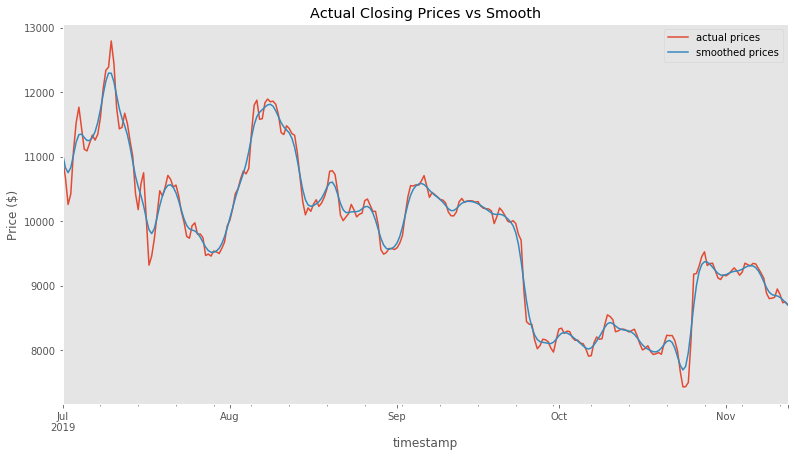

In [12]:
plt.figure(figsize=(13,7))
data_df.close.loc[pd.datetime(2019,7,1):].plot()
data_df.smooth_prices.loc[pd.datetime(2019,7,1):].plot()
plt.grid(False)
plt.title('Actual Closing Prices vs Smooth')
plt.ylabel('Price ($)')
plt.legend(['actual prices', 'smoothed prices'])
plt.show();

From this smoothed price timeseries we can extract local minima and maxima (orange points in the plots below.)

The author uses the minima and maxima from the smoothed timeseries to identify the true local minima and maxima in the original timeseres by taking the maximum/minimum price within a t-1, t+1 window around the smooth timeseries maxima/minima (purple points in the plots below). We use these minima and maxima from the original price data to look for the given technical patterns.

You can see in the plots below, that finding minima and maxima using the kernel regression allows us to skip over minima and maxima that are **too local**.

In [13]:
from scipy.signal import argrelextrema

In [14]:
smooth_prices = data_df.smooth_prices
msft_prices = data_df.close

In [15]:
local_max = argrelextrema(smooth_prices.values, np.greater)[0]
local_min = argrelextrema(smooth_prices.values, np.less)[0]

In [16]:
local_max_dt = smooth_prices.iloc[local_max].index.values
local_min_dt = smooth_prices.iloc[local_min].index.values

In [17]:
price_local_max_dt = []
for i in local_max:
    if (i>1) and (i<len(msft_prices)-1):
        price_local_max_dt.append(msft_prices.iloc[i-2:i+2].argmax())

price_local_min_dt = []
for i in local_min:
    if (i>1) and (i<len(msft_prices)-1):
        price_local_min_dt.append(msft_prices.iloc[i-2:i+2].argmin())

In [18]:
start = pd.datetime(2019,1,1)
end = pd.datetime(2019,4,1)

def plot_window(prices, smooth_prices, smooth_maxima_dt, smooth_minima_dt,
                price_maxima_dt, price_minima_dt, start, end, ax=None):
    if ax is None:
        fig = plt.figure(figsize=(10,5))
        ax = fig.add_subplot(111)

    prices_ = prices.loc[start:end]
    prices_.plot(ax=ax,label='Actual')
    smooth_prices_ = smooth_prices.loc[start:end]
    smooth_prices_.plot(ax=ax,label='Smoothed')
    
    smooth_max = smooth_prices_.loc[smooth_maxima_dt]
    smooth_min = smooth_prices_.loc[smooth_minima_dt]
    price_max = prices_.loc[price_maxima_dt]
    price_min = prices_.loc[price_minima_dt]

    ax.scatter(smooth_max.index.values, smooth_max.values, s=50, color='orange')
    ax.scatter(smooth_min.index.values, smooth_min.values, s=50, color='orange')
    
    ax.scatter(price_max.index.values, price_max.values, s=50, color='purple')
    ax.scatter(price_min.index.values, price_min.values, s=50, color='purple')
    
    plt.grid(False)
    #plt.legend()
    plt.tight_layout()
    plt.show();

### Visualizing local minima and maxima values actual vs smoothed

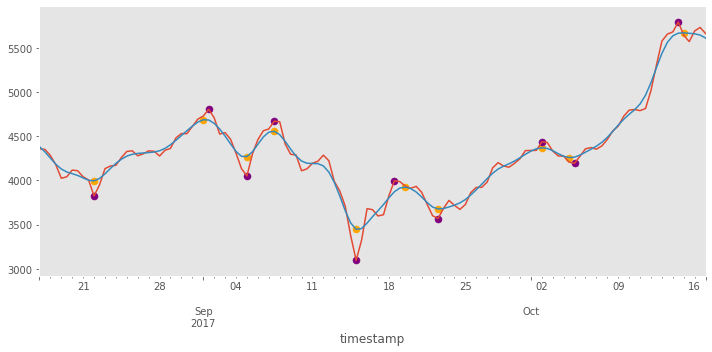

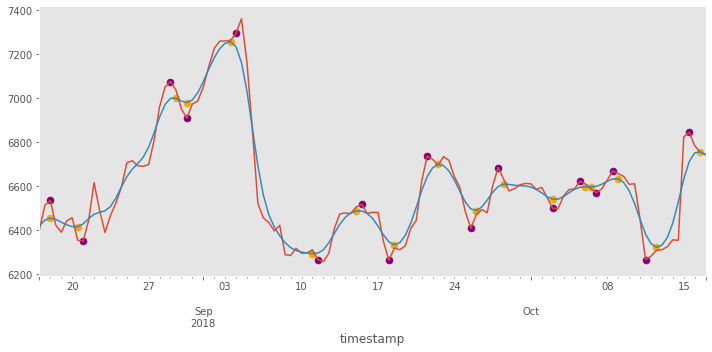

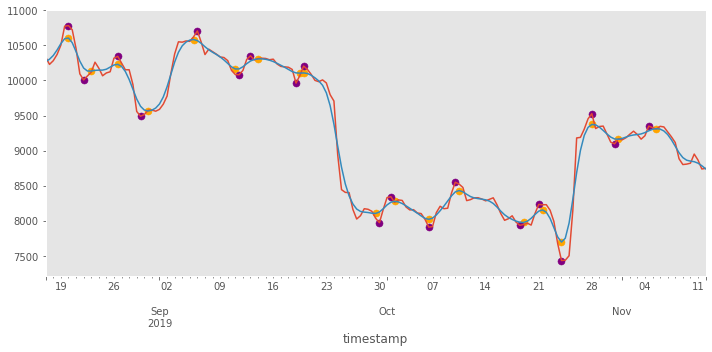

In [19]:
plot_window(msft_prices, smooth_prices, local_max_dt, local_min_dt, price_local_max_dt, 
            price_local_min_dt, pd.datetime(2017,8,17), pd.datetime(2017,10,17))
plot_window(msft_prices, smooth_prices, local_max_dt, local_min_dt, price_local_max_dt, 
            price_local_min_dt,pd.datetime(2018,8,17), pd.datetime(2018,10,17))
plot_window(msft_prices, smooth_prices, local_max_dt, local_min_dt, price_local_max_dt, 
            price_local_min_dt, pd.datetime(2019,8,17), pd.datetime(2019,11,12))

In [20]:
# Let's throw what we have so far into a function:
def find_max_min(prices):
    prices_ = prices.copy()
    prices_.index = linspace(1., len(prices_), len(prices_))
    kr = KernelReg([prices_.values], [prices_.index.values], var_type='c', bw=[1.8])
    f = kr.fit([prices_.index.values])
    smooth_prices = pd.Series(data=f[0], index=prices.index)
    
    local_max = argrelextrema(smooth_prices.values, np.greater)[0]
    local_min = argrelextrema(smooth_prices.values, np.less)[0]
    
    price_local_max_dt = []
    for i in local_max:
        if (i>1) and (i<len(prices)-1):
            price_local_max_dt.append(prices.iloc[i-2:i+2].argmax())

    price_local_min_dt = []
    for i in local_min:
        if (i>1) and (i<len(prices)-1):
            price_local_min_dt.append(prices.iloc[i-2:i+2].argmin())
        
    prices.name = 'price'
    maxima = pd.DataFrame(prices.loc[price_local_max_dt])
    minima = pd.DataFrame(prices.loc[price_local_min_dt])
    max_min = pd.concat([maxima, minima]).sort_index()
    max_min.index.name = 'date'
    max_min = max_min.reset_index()
    max_min = max_min[~max_min.date.duplicated()]
    p = prices.reset_index()
    max_min['day_num'] = p[p['timestamp'].isin(max_min.date)].index.values
    max_min = max_min.set_index('day_num').price
    
    return max_min

In [21]:
max_min = find_max_min(msft_prices)

# Pattern Identification

#### You can find the pattern definitions on Pattern Identification on page 1716 of the paper. 

In [22]:
from collections import defaultdict

def find_patterns(max_min):
    patterns = defaultdict(list)

    for i in range(5, len(max_min)):
        window = max_min.iloc[i-5:i]

        # pattern must play out in less than 36 days
        if window.index[-1] - window.index[0] > 35:
            continue

        # Using the notation from the paper to avoid mistakes
        e1 = window.iloc[0]
        e2 = window.iloc[1]
        e3 = window.iloc[2]
        e4 = window.iloc[3]
        e5 = window.iloc[4]

        rtop_g1 = np.mean([e1,e3,e5])
        rtop_g2 = np.mean([e2,e4])
        
        # Head and Shoulders
        if (e1 > e2) and (e3 > e1) and (e3 > e5) and \
            (abs(e1 - e5) <= 0.03*np.mean([e1,e5])) and \
            (abs(e2 - e4) <= 0.03*np.mean([e2,e4])):
                patterns['HS'].append((window.index[0], window.index[-1]))

        # Inverse Head and Shoulders
        elif (e1 < e2) and (e3 < e1) and (e3 < e5) and \
            (abs(e1 - e5) <= 0.03*np.mean([e1,e5])) and \
            (abs(e2 - e4) <= 0.03*np.mean([e2,e4])):
                patterns['IHS'].append((window.index[0], window.index[-1]))

        # Broadening Top
        elif (e1 > e2) and (e1 < e3) and (e3 < e5) and (e2 > e4):
            patterns['BTOP'].append((window.index[0], window.index[-1]))

        # Broadening Bottom
        elif (e1 < e2) and (e1 > e3) and (e3 > e5) and (e2 < e4):
            patterns['BBOT'].append((window.index[0], window.index[-1]))

        # Triangle Top
        elif (e1 > e2) and (e1 > e3) and (e3 > e5) and (e2 < e4):
            patterns['TTOP'].append((window.index[0], window.index[-1]))

        # Triangle Bottom
        elif (e1 < e2) and (e1 < e3) and (e3 < e5) and (e2 > e4):
            patterns['TBOT'].append((window.index[0], window.index[-1]))

        # Rectangle Top
        elif (e1 > e2) and (abs(e1-rtop_g1)/rtop_g1 < 0.0075) and \
            (abs(e3-rtop_g1)/rtop_g1 < 0.0075) and (abs(e5-rtop_g1)/rtop_g1 < 0.0075) and \
            (abs(e2-rtop_g2)/rtop_g2 < 0.0075) and (abs(e4-rtop_g2)/rtop_g2 < 0.0075) and \
            (min(e1, e3, e5) > max(e2, e4)):

            patterns['RTOP'].append((window.index[0], window.index[-1]))

        # Rectangle Bottom
        elif (e1 < e2) and (abs(e1-rtop_g1)/rtop_g1 < 0.0075) and \
            (abs(e3-rtop_g1)/rtop_g1 < 0.0075) and (abs(e5-rtop_g1)/rtop_g1 < 0.0075) and \
            (abs(e2-rtop_g2)/rtop_g2 < 0.0075) and (abs(e4-rtop_g2)/rtop_g2 < 0.0075) and \
            (max(e1, e3, e5) > min(e2, e4)):
            patterns['RBOT'].append((window.index[0], window.index[-1]))
            
    return patterns

In [23]:
patterns = find_patterns(max_min)

### Visualizing pattern occurences

HS


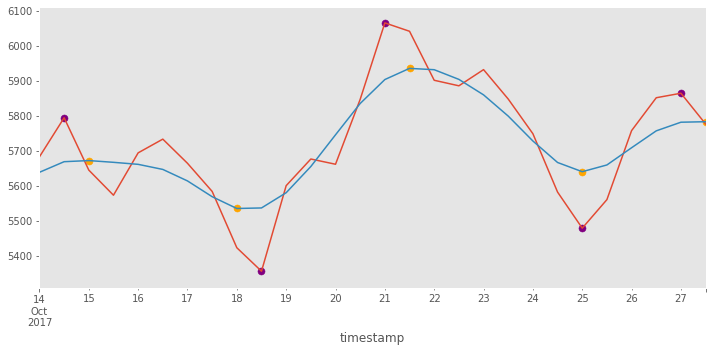

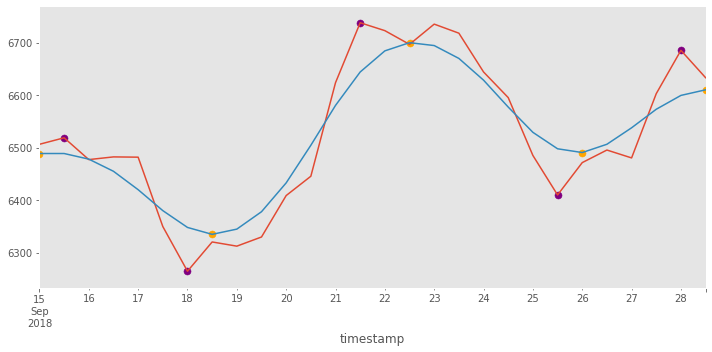

TBOT


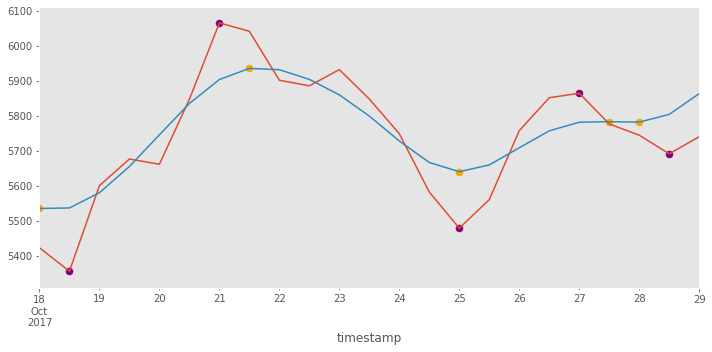

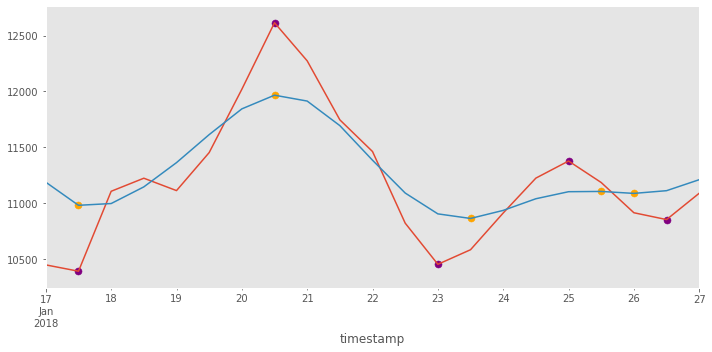

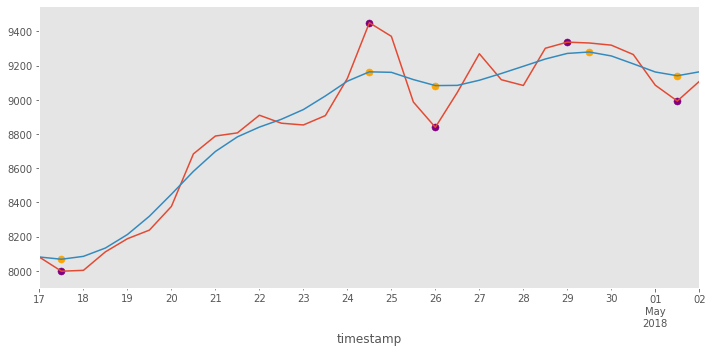

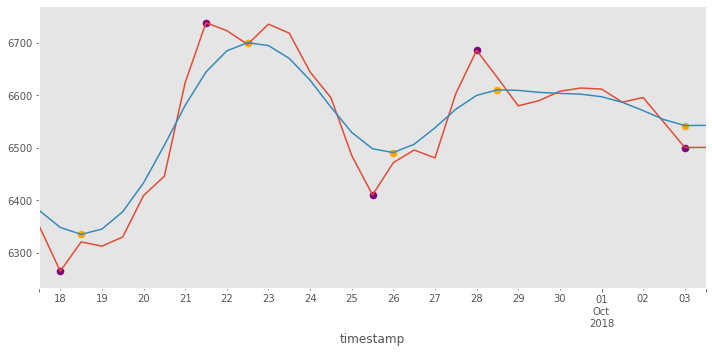

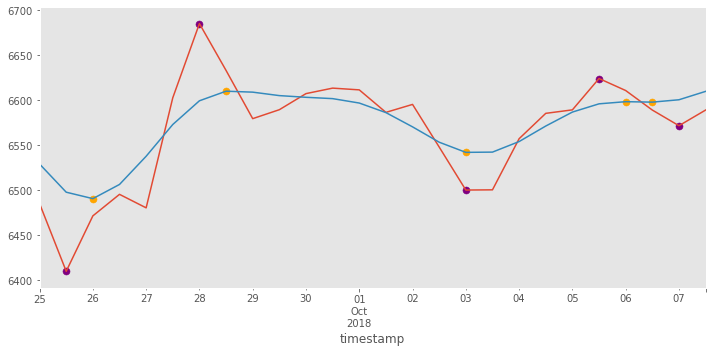

TTOP


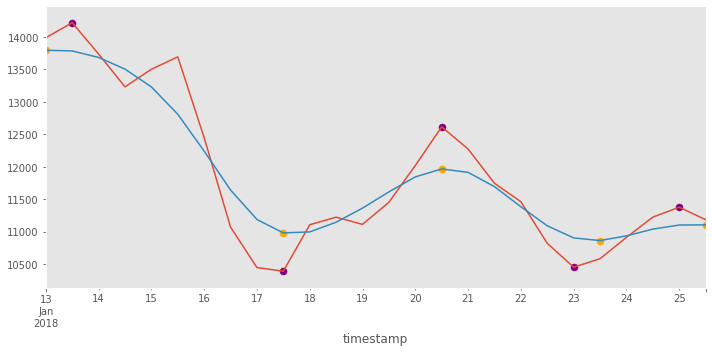

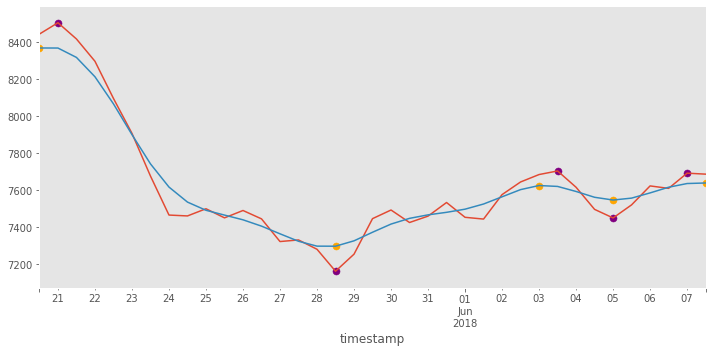

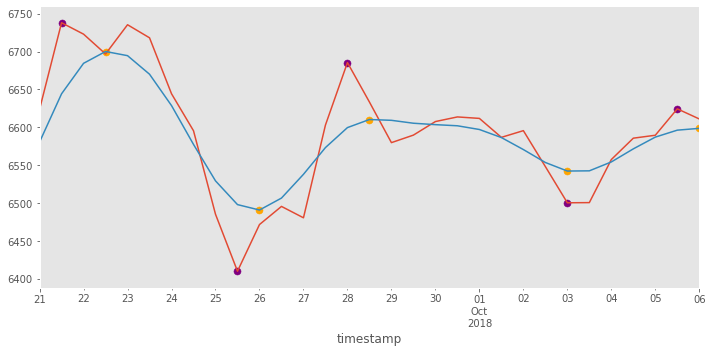

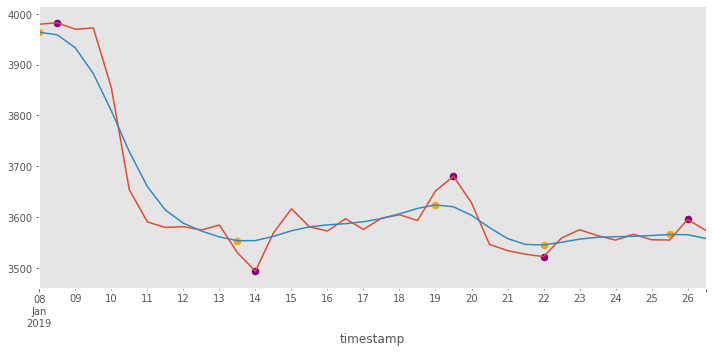

BTOP


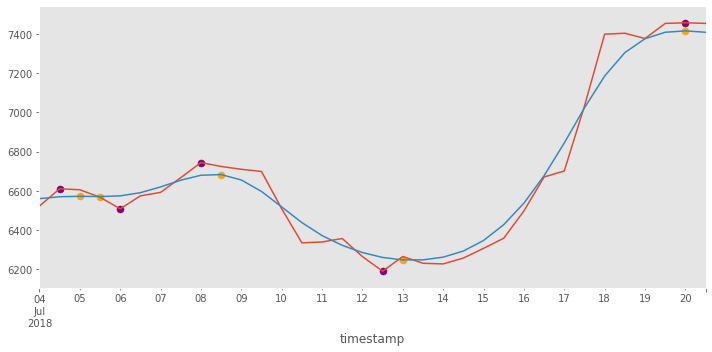

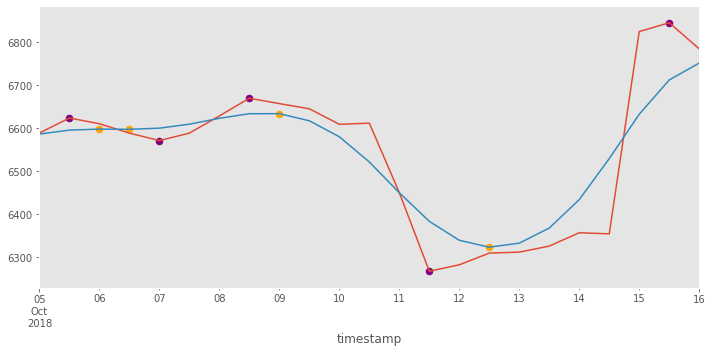

RTOP


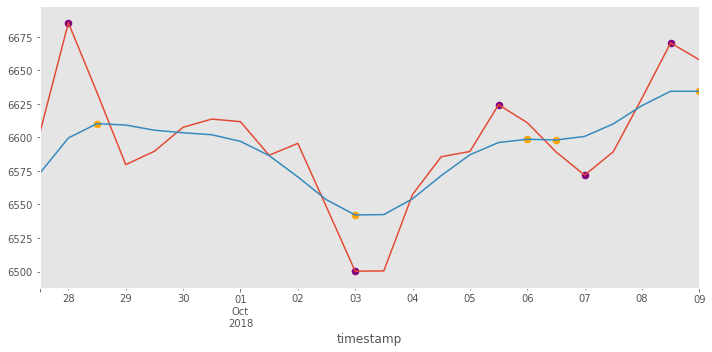

IHS


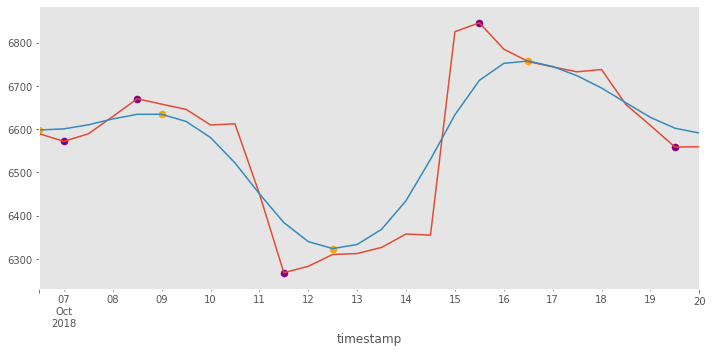

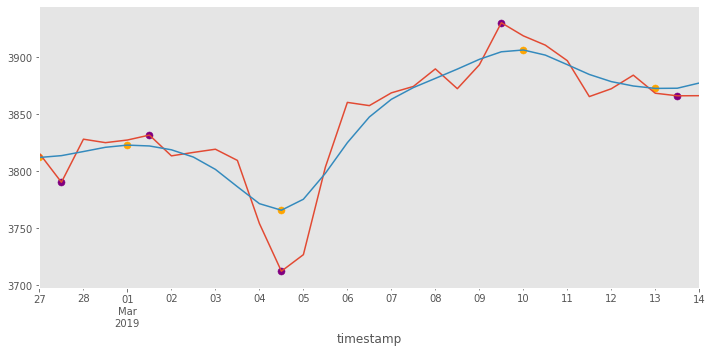

In [24]:
for name, end_day_nums in patterns.items():
    print(name)
    i = 0
    for sd, ed in end_day_nums:
        s = msft_prices.index[sd-1]
        e = msft_prices.index[ed+1]
        plot_window(msft_prices, smooth_prices,local_max_dt, local_min_dt, 
                    price_local_max_dt, price_local_min_dt,
                    s, e, ax=None)
        i+=1
    plt.show();

In [25]:
for name, end_day_nums in patterns.items():
    print("{}: {} occurences".format(name, len(end_day_nums)))

HS: 2 occurences
TBOT: 5 occurences
TTOP: 4 occurences
BTOP: 2 occurences
RTOP: 1 occurences
IHS: 2 occurences


# Predictive Power of Technical Patterns

Next, we want to know if our technical patterns can predict forward returns. The proported return sign predicted by each of the patterns is as follows:

Bullish:
- Inverse Head and Shoulders
- Broadening Bottom 
- Rectangle Bottom
- Triangle Bottom

Bearish:
- Head and Shoulders
- Broadening Top
- Rectangle Top
- Triangle Top

Following the authors, I account for a 4 day "observation lag" before the computing the forward return. This lag makes sense, as you would not know a point is a local max/min until the days after it has been observed. 

I also follow the authors by normalizing forward returns.

In [26]:
def compute_pattern_returns(prices, indentification_lag=4):
    max_min = find_max_min(prices)
    patterns = find_patterns(max_min)
    returns = (prices.pct_change(1)
                          .shift(-1)
                          .reset_index(drop=True)
                          .dropna())

    demeaned_returns = (returns - returns.mean()) / returns.std()

    pattern_mean_returns = pd.Series()
    for name, start_end_day_nums in patterns.items():
        if not isinstance(start_end_day_nums, list):
            end_day_nums = [end_day_nums]
        lagged_end_days = map(lambda x: x[1] + indentification_lag, start_end_day_nums)
        pattern_mean_returns[name] = demeaned_returns.loc[lagged_end_days].mean()
    
    return pattern_mean_returns

In [27]:
compute_pattern_returns(msft_prices)

HS      0.852105
TBOT   -0.002318
TTOP   -0.076128
BTOP    0.051410
RTOP   -1.086759
IHS     0.245055
dtype: float64

In [28]:
#for symbol in list_of_symbols:
LTC = get_all_binance('LTCUSDT', '12h', save = False)
ETH = get_all_binance('ETHUSDT', '12h', save = False)

All caught up..!
All caught up..!


In [29]:
cols = ['open', 'high', 'low', 'close', 'volume', 'timestamp']

LTC.columns = cols
LTC['timestamp'] = pd.to_datetime(LTC['timestamp'], unit='ms')
LTC.index = LTC.timestamp
LTC = LTC.drop('timestamp',axis=1)

ETH.columns = cols
ETH['timestamp'] = pd.to_datetime(ETH['timestamp'], unit='ms')
ETH.index = ETH.timestamp
ETH = ETH.drop('timestamp',axis=1)

In [30]:
LTC.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1399 entries, 2017-12-13 00:00:00 to 2019-11-12 12:00:00
Data columns (total 5 columns):
open      1399 non-null float64
high      1399 non-null float64
low       1399 non-null float64
close     1399 non-null float64
volume    1399 non-null object
dtypes: float64(4), object(1)
memory usage: 65.6+ KB


In [31]:
ETH.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1635 entries, 2017-08-17 00:00:00 to 2019-11-12 12:00:00
Data columns (total 5 columns):
open      1635 non-null float64
high      1635 non-null float64
low       1635 non-null float64
close     1635 non-null float64
volume    1635 non-null object
dtypes: float64(4), object(1)
memory usage: 76.6+ KB


In [32]:
BTCUSDT = data_df.loc[pd.datetime(2017,12,13):]
ETHUSDT = ETH.loc[pd.datetime(2017,12,13):]
LTCUSDT = LTC.loc[pd.datetime(2017,12,13):]

In [33]:
prices = pd.DataFrame({'BTCUSDT': BTCUSDT.close,
              'ETHUSDT': ETHUSDT.close,
              'LTCUSDT': LTCUSDT.close})

In [34]:
prices.head()

,BTCUSDT,ETHUSDT,LTCUSDT
timestamp,,,
2017-12-13 00:00:00,15851.1800,607.9125,287.9975
2017-12-13 12:00:00,15789.5975,655.7375,288.7525
2017-12-14 00:00:00,16006.0850,696.3850,289.4325
2017-12-14 12:00:00,16131.2300,669.5875,275.2700
2017-12-15 00:00:00,17128.9125,649.3625,263.1500


In [35]:
pattern_returns = prices.apply(compute_pattern_returns)
pattern_returns = pattern_returns.T
pattern_returns = pattern_returns.fillna(0)

In [36]:
pattern_returns

,BBOT,BTOP,HS,IHS,RTOP,TBOT,TTOP
BTCUSDT,0.000000,0.093514,0.050214,0.296452,-1.099279,-0.019163,-0.040145
ETHUSDT,0.015505,0.000000,0.292671,0.000000,0.000000,0.761538,-0.607697
LTCUSDT,0.312845,-0.403134,-1.256805,-0.230526,-0.197836,0.321670,-0.411378


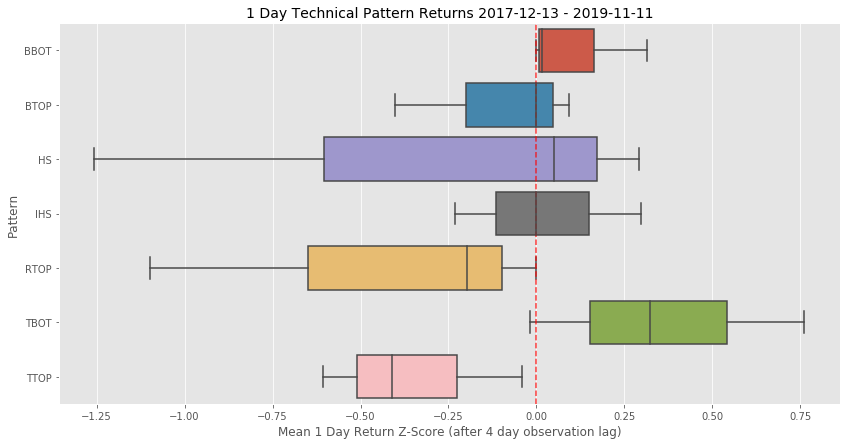

In [37]:
plt.figure(figsize=(14,7))
sns.boxplot(data=pattern_returns, orient='h')
plt.axvline(x=0, lw=1.5, ls='--', color='red', alpha=0.75)
plt.title('1 Day Technical Pattern Returns 2017-12-13 - 2019-11-11', size=14)
plt.xlabel('Mean 1 Day Return Z-Score (after 4 day observation lag)')
plt.ylabel('Pattern')
plt.show();

Somewhat surprisingly, it appears the patterns have some predictive power with the signs we expected. I'm concerned that the kernel regression was incorporating some lookahead bias that has not been fully mitigated by the four day observation lag. Next step will be to throw this into an algorithm and test for predictive power in a no-look-ahead environment. 